In [1]:
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from monai.transforms import Activations
from monai.metrics import ROCAUCMetric

from sklearn import metrics
import sklearn

import misc


c:\Users\MacRaeDC\AppData\Local\anaconda3\envs\HNC_conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
\\zkh\appdata\RTDicom\Projectline_HNC_modelling\Users\Daniel MacRae\DL_NTCP_Xerostomia\models\convnext_original.py:171: UserWarning: Overwriting convnext_tiny in registry with models.convnext_original.convnext_tiny. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
\\zkh\appdata\RTDicom\Projectline_HNC_modelling\Users\Daniel MacRae\DL_NTCP_Xerostomia\models\convnext_original.py:181: UserWarning: Overwriting convnext_small in registry with models.convnext_original.convnext_small. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
\\zkh\appdata\RTDicom\Pr

In [2]:
def get_predictions_filename(folder_name):
    if "dcnn_lrelu" in folder_name:
        fold_test_preds_filename = "dcnn_lrelu_outputs.csv"
        ens_test_preds_filename = "dcnn_lrelu_ens_outputs.csv"
        #print('hi')

    return fold_test_preds_filename, ens_test_preds_filename



softmax_act = Activations(softmax=True)
auc_metric = ROCAUCMetric()

In [20]:
from torcheval.metrics import MulticlassAUROC, BinaryAUROC, BinaryF1Score, BinaryConfusionMatrix, BinaryAUPRC, BinaryRecall
from torcheval.metrics.functional.classification import binary_recall


def collect_metrics(targets, predictions, thresh = 0.5):
    preds_binary = torch.round(torch.tensor([1 if p > thresh else 0 for p in predictions])).type(torch.int)
    #print(preds_binary.dtype)

    # precision
    precision_metric = BinaryAUPRC() 
    precision_metric.update(input=predictions, target=targets)
    precision_score = precision_metric.compute()
    precision_metric.reset()

    # recall
    recall_metric = BinaryRecall()
    recall_metric.update(input=preds_binary, target=targets)
    recall_score = recall_metric.compute()
    recall_metric.reset()

    # F1-score
    f1_metric = BinaryF1Score()
    f1_metric.update(input=preds_binary, target=targets)
    f1_score = f1_metric.compute()
    f1_metric.reset()

    # AUC
    auc_metric = BinaryAUROC()
    auc_metric.update(input=predictions, target=targets)
    auc_score = auc_metric.compute()
    auc_metric.reset()


    CM = BinaryConfusionMatrix()
    CM.update(input=preds_binary, target=targets)
    cm = CM.compute()
    CM.reset()

    """
    print(f"  precision score: {precision_score:.3f}")
    print(f"  recall score:    {recall_score:.3f}")
    print(f"  f1 score:        {f1_score:.3f}")
    print(f"  AUC score:       {auc_score:.3f}")
    print("  Confusion Matrix:   ")
    print(cm)
    """

    return [precision_score, recall_score, f1_score, auc_score, cm]


  precision score: 0.592
  recall score:    0.369
  f1 score:        0.441
  AUC score:       0.756
  Confusion Matrix:   
tensor([[77.3000, 11.7000],
        [30.9000, 18.1000]])


[]

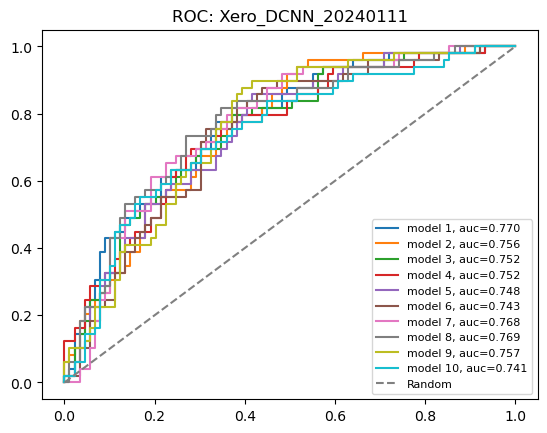

In [40]:
root = "experiments"
experiment_name = "Xero_DCNN_BinaryOutput_20240111"
experiment_name="Xero_DCNN_20240111"
#experiment_name='xero_no_baseline'
#experiment_name='xero_no_clinical'


folder_path = os.path.join(root, experiment_name)

cv_fold_folders = next(os.walk(folder_path))[1] # find all subfolders (each subfolder is a cv fold)

plt.figure(0).clf()

avg_precision_score, avg_recall_score, avg_f1_score, avg_auc_score, avg_cm = 0,0,0,0, torch.tensor([[0,0],[0,0]]).type(torch.float)

folds = len(cv_fold_folders)

for idx, cv_folder_name in enumerate(cv_fold_folders):
    #print(f"FOLD {idx}")
    # make the filenames
    fold_test_preds_filename, ens_test_preds_filename = get_predictions_filename(cv_folder_name)

    #print(folder_name, fold_test_preds_filename)
    #print(os.listdir(os.path.join(folder, folder_name)))

    preds_file_dir = os.path.join(os.path.join(folder_path, cv_folder_name), fold_test_preds_filename)
    #

    # open the predictions file
    df_preds = pd.read_csv(preds_file_dir, delimiter=";")

    # get the predictions and true labels out
    preds = [list(row) for row in zip(df_preds['pred_0'], df_preds['pred_1'])]

    preds_single_col= list(df_preds['pred_1'])
    
    #preds_second_col = list(df_preds['pred_1'])  # the column of just the xero=yes column
    
    #y_true = [list(row) for row in zip(df_preds['true_0'], df_preds['true_1'])]
    y_true = list(df_preds['true_1'])  # again just the second col

    # tensor formats, just in case
    tensor_preds = torch.tensor(preds) 
    tensor_y_true = torch.tensor(y_true)

    # calculate fpr, fpr, auc, and plot it
    plt.figure(0)
    fpr, tpr, thresh = metrics.roc_curve(y_true, preds_single_col)  
    auc_score = metrics.roc_auc_score(y_true, preds_single_col)
    plt.plot(fpr, tpr, label=f"model {idx+1}, auc={auc_score:.3f}")


    targets_binarised =torch.tensor(y_true).type(torch.int)
    tensor_preds_single_col = torch.tensor(preds_single_col).type(torch.float)
    

    precision_score, recall_score, f1_score, auc_score, cm = collect_metrics(targets_binarised, tensor_preds_single_col, thresh=0.5)

    avg_precision_score += precision_score /folds
    avg_recall_score += recall_score/folds
    avg_f1_score += f1_score/folds
    avg_auc_score += auc_score/folds
    avg_cm += cm/folds
    #print(cm)
    #print(" ")

    #plt.figure(1)
    #plt.plot(tpr, fpr, label=f"AAAHHH {idx}, auc={auc_score:.2f}")



print(f"  precision score: {avg_precision_score:.3f}")
print(f"  recall score:    {avg_recall_score:.3f}")
print(f"  f1 score:        {avg_f1_score:.3f}")
print(f"  AUC score:       {avg_auc_score:.3f}")
print("  Confusion Matrix:   ")
print(avg_cm)


plt.figure(0)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
# fpr, tpr, thresh = metrics.roc_curve(y_true_binary, list(df_preds['pred_1']))
# auc = metrics.roc_auc_score(y_true_binary, list(df_preds['pred_1']))
# 
plt.title("ROC: "+ experiment_name)
plt.legend(loc='lower right', prop={'size': 8})
plt.plot()



In [10]:
from torch import tensor
#from torchmetrics.classification import BinaryRecall
target = tensor([0, 1, 0, 1, 0, 1])
preds = tensor([0, 0, 1, 1, 0, 1])
#metric = binary_recall()
binary_recall(preds, target)

tensor(0.6667)

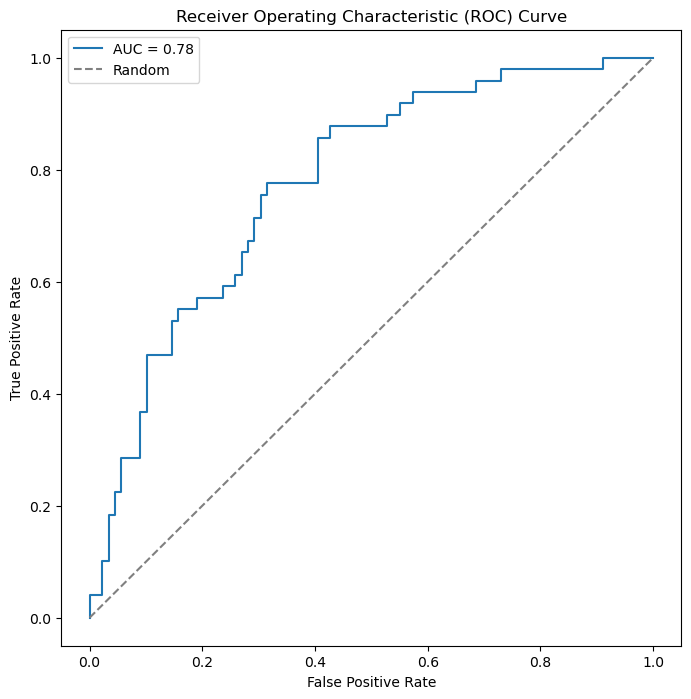

{'Precision': 0.6486486486486487, 'Recall': 0.4897959183673469, 'F1 Score': 0.5581395348837208, 'AUC': 0.7764274249025452}


In [51]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def calculate_classification_metrics(true_labels, predicted_probabilities, threshold=0.5):
    # Convert probabilities to binary predictions based on the threshold
    predicted_labels = [1 if prob >= threshold else 0 for prob in predicted_probabilities]

    # Calculate precision, recall, and F1 score
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    # Calculate AUC and plot ROC curve
    auc = roc_auc_score(true_labels, predicted_probabilities)
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)

    # Plot ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    # Return metrics
    metrics = {
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc
    }

    return metrics

# Example usage:
true_labels = targets_binarised
predicted_probabilities = tensor_preds_single_col

metrics = calculate_classification_metrics(true_labels, predicted_probabilities)
print(metrics)

In [57]:
from sklearn.metrics import classification_report

preds_binary = [int(i > .5) for i in preds_second_col]

print(classification_report(y_true_binary, preds_binary))

              precision    recall  f1-score   support

         0.0       0.75      0.85      0.80        89
         1.0       0.65      0.49      0.56        49

    accuracy                           0.72       138
   macro avg       0.70      0.67      0.68       138
weighted avg       0.72      0.72      0.71       138



In [9]:
auc_metric(tensor_preds, tensor_y_true)
auc_value = auc_metric.aggregate()
print(auc_value)
auc_metric.reset()

TypeError: 'BinaryAUROC' object is not callable

In [99]:
tensor_preds_binary = [torch.as_tensor(x) for x in preds_binary]
tensor_y_true_binary = [torch.as_tensor(x) for x in y_true_binary]

auc_metric(tensor_preds_binary, tensor_y_true_binary)
auc_value = auc_metric.aggregate()
print(auc_value)
auc_metric.reset()

0.622907590002293


In [108]:
#acc = metrics.f1_score(y_true_binary, preds)
sklearn.metrics.roc_auc_score(y_true_binary, list(df_preds['pred_1']))


0.741343728502637

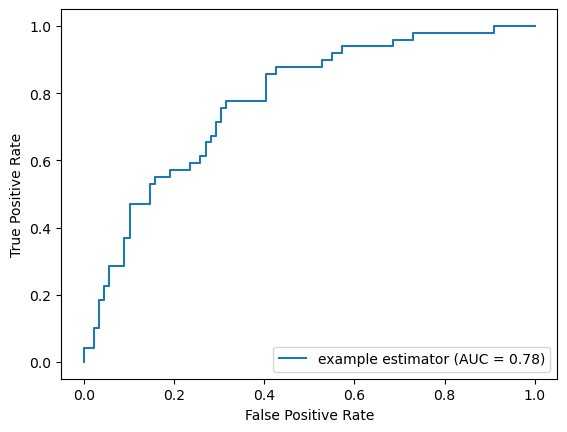

In [96]:

fpr, tpr, thresholds = metrics.roc_curve(y_true_binary, list(df_preds['pred_1']))
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()

In [150]:
ens_file_dir = "experiments/Xero_DCNN_20240111/20240110_152732_4_9_16_dcnn_lrelu_params_140144_auc_tr_0.782_lr_0.778_val_0.715_lr_0.751_test_0.741_lr_0.752/dcnn_lrelu_ens_outputs.csv"

df_ens_preds = pd.read_csv(ens_file_dir, delimiter=";")
#print(df_preds.head())

ens_preds = [list(row) for row in zip(df_ens_preds['pred_0'], df_ens_preds['pred_1'])]
ens_preds_binary = [1 if p2 > p1 else 0 for [p1,p2] in preds]

ens_y_true = [list(row) for row in zip(df_ens_preds['true_0'], df_ens_preds['true_1'])]
ens_y_true_binary = list(df_ens_preds['true_1'])

metrics.roc_auc_score(ens_y_true_binary, list(df_ens_preds['pred_1']), average='macro')

0.7612932813574869

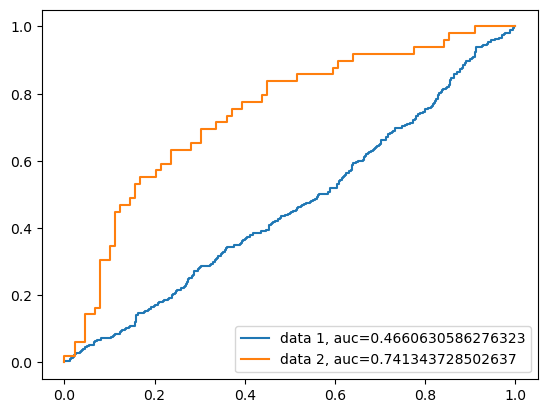

In [106]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

plt.figure(0).clf()

pred = np.random.rand(1000)
label = np.random.randint(2, size=1000)
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_true_binary, list(df_preds['pred_1']))
auc = metrics.roc_auc_score(y_true_binary, list(df_preds['pred_1']))
plt.plot(fpr,tpr,label="data 2, auc="+str(auc))

plt.legend(loc=0)